In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. GERAÇÃO DE DADOS ---
np.random.seed(42)
n_samples = 3000
order = 5  # M=5 seções lattice

# Gerando sinal com variação abrupta de energia (Teste de Robustez)
# O NLRLS deve lidar bem com a mudança de escala do sinal
x_white = (np.random.randn(n_samples) + 1j * np.random.randn(n_samples)) / np.sqrt(2)
# Primeira metade com amplitude 1.0, segunda metade com amplitude 5.0
x_white[n_samples//2:] *= 5.0

# Filtro AR para criar correlação
b_ar, a_ar = [1], [1, -1.2, 0.7]
x = signal.lfilter(b_ar, a_ar, x_white)

# Planta Desconhecida
w_true = np.array([0.7, -0.4, 0.2, -0.1, 0.05, -0.02])
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
d = d_clean + 0.01 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

# --- 2. EXECUÇÃO DO NLRLS ---
# lambda_factor: 0.99
# epsilon: Regularização para evitar divisões por zero e inicializar xi_half
filt_nlrls = pdf.NormalizedLRLS(
    filter_order=order,
    lambda_factor=0.999,
    epsilon=1e-2
)

result = filt_nlrls.optimize(x, d, verbose=True, return_internal_states=True)

[NormalizedLRLS] Completed in 195.43 ms


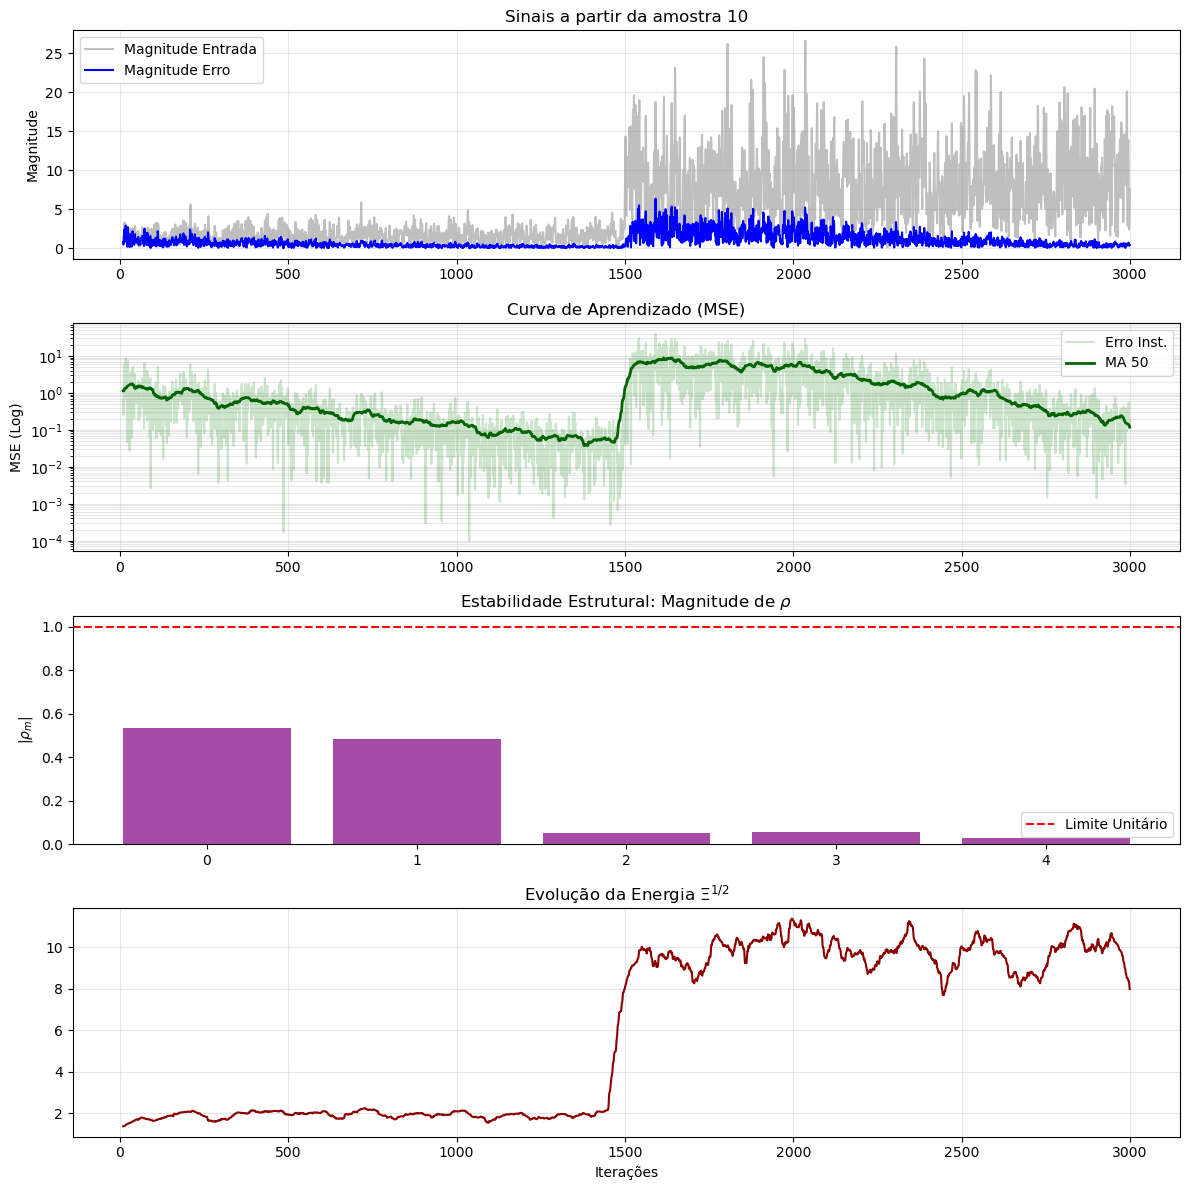

In [3]:
# --- 3. ANÁLISE VISUAL (Versão Robusta) ---
offset = 10 
plt.figure(figsize=(12, 12))

# 1. Preparação dos dados com corte
mse_full = result.mse()
t = np.arange(len(mse_full))

# Slicing: ignorando os primeiros 10 pontos
t_cut = t[offset:]
mse_cut = mse_full[offset:]
x_cut = np.abs(x[offset:])
err_cut = np.abs(result.errors[offset:])

# Subplot 1: Magnitude
plt.subplot(4, 1, 1)
plt.plot(t_cut, x_cut, label='Magnitude Entrada', alpha=0.5, color='gray')
plt.plot(t_cut, err_cut, label='Magnitude Erro', color='blue')
plt.title(f'Sinais a partir da amostra {offset}')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: MSE (Onde deu o erro anteriormente)
plt.subplot(4, 1, 2)
plt.semilogy(t_cut, mse_cut, label='Erro Inst.', alpha=0.2, color='green')

# Cálculo da Média Móvel sobre os dados já cortados
window = 50
if len(mse_cut) > window:
    mse_smooth = np.convolve(mse_cut, np.ones(window)/window, mode='same')
    plt.semilogy(t_cut, mse_smooth, label=f'MA {window}', color='darkgreen', lw=2)

plt.title('Curva de Aprendizado (MSE)')
plt.ylabel('MSE (Log)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 3: Coeficientes de Reflexão (Final)
plt.subplot(4, 1, 3)
rho_final = np.abs(result.extra["rho"])
plt.bar(range(len(rho_final)), rho_final, color='purple', alpha=0.7)
plt.axhline(y=1.0, color='red', linestyle='--', label='Limite Unitário')
plt.title(r'Estabilidade Estrutural: Magnitude de $\rho$')
plt.ylabel(r'$|\rho_m|$')
plt.legend()

# Subplot 4: Energia
plt.subplot(4, 1, 4)
# Usando 'same' na convolução para manter o tamanho original do sinal x
energy_full = np.sqrt(np.convolve(np.abs(x)**2, np.ones(100)/100, mode='same'))
plt.plot(t_cut, energy_full[offset:], label='Raiz da Energia', color='darkred')
plt.title(r'Evolução da Energia $\Xi^{1/2}$')
plt.xlabel('Iterações')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()